# Introducción


Para el entrenamiento del modelo en la detección de reseñas falsas, usaremos el conjunto de datos proporcionados por la plataforma <a href="https://www.yelp.es">Yelp</a>, conocidos como <A Href="https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset/data">Yelp Dataset</A>, este dataset es un conjunto de datos público que la empresa Yelp pone a disposición para fines académicos, educativos y de investigación personal.  En esencia, la colección de datos son un subconjunto de datos reales extraídos de la plataforma de Yelp y anonimizado hasta cierto punto.

<a href="https://business.yelp.com/data/resources/open-dataset/"><img src=https://business.yelp.com/wp-content/themes/yelp-b2b/assets/branding/yelp-data-logo.svg></a>

# Librerías

In [1]:
import polars as pl
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2') 
import seaborn as sns

import time

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión polars: {pl.__version__}")
print(f"{color}Versión pyarrow: {pyarrow.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión pandas: 2.2.3
Versión polars: 1.27.1
Versión pyarrow: 16.1.0
Versión numpy: 2.0.1


# Datos

## Yelp dataset

El dataset se distribuye en varios archivos en formato JSON (JavaScript Object Notation), cada uno representando un tipo diferente de información. Los componentes principales suelen ser:

* Información de Negocios (business.json): Detalles sobre los establecimientos listados en Yelp, como:
    * Nombre, dirección, coordenadas geográficas.
    * Categorías (restaurante, tienda, peluquería, etc.).
    * Atributos (acepta tarjetas, tiene Wi-Fi, bueno para grupos, etc.).
    * Horarios de apertura.
    * Puntuación media (estrellas).
    * Número de reseñas recibidas.

* Reseñas (review.json): El texto de las reseñas escritas por los usuarios, junto con metadatos como:
    * El texto completo de la reseña.
    * La calificación en estrellas otorgada (de 1 a 5).
    * La fecha de la reseña.
    * El ID del usuario que la escribió.
    * El ID del negocio reseñado.
    * Votos recibidos por la reseña (útil, divertida, genial - "useful, funny, cool").

* Información de Usuarios (user.json): Datos sobre los usuarios que escriben las reseñas:
    * ID del usuario.
    * Nombre (a menudo solo el primer nombre o un identificador).
    * Número total de reseñas escritas.
    * Tiempo siendo usuario de Yelp.
    * Lista de amigos (IDs de otros usuarios).
    * Puntuación media de las reseñas que ha escrito.
    * Número total de votos recibidos por sus reseñas.
    * Estado "Elite" (si lo tiene y en qué años).

* Check-ins (checkin.json): Registros de cuándo los usuarios han indicado ("hecho check-in") que han visitado un negocio.

* Consejos (tip.json): Textos cortos o consejos que los usuarios dejan sobre los negocios, distintos de las reseñas completas.

In [2]:
# Fichero de reseñas
review_file_path = r'./fakereviews/yelp_academic_dataset_review.json'
# Fichero de Información de usuarios
user_file_path = r'./fakereviews/yelp_academic_dataset_user.json'
# Fichero Consejos
tip_file_path = r'./fakereviews/yelp_academic_dataset_tip.json'
# Fichero de Check-ins
chekin_file_path = r'./fakereviews/yelp_academic_dataset_checkin.json'
# Fichero de Información de negocios
business_file_path = r'./fakereviews/yelp_academic_dataset_business.json'

# Análisis Exploratorio

A continuación realizamos un análisis exploratorio de datos (EDA), motivado principalmente por la naturaleza intrínseca y la heterogeneidad de los datos. Este proceso se desarrollará siguiendo una serie de etapas consideradas fundamentales para el propósito establecido.

1. Entender la estructura y complejidad de los datos:
    
    Cada uno de los conjuntos de datos puede estar integrado por múltiples archivos, como se observa en el caso del "Yelp Dataset". En consecuencia, se recomienda la unificación de estos archivos para simplificar la comprensión de la información y ofrecer una perspectiva clara del volumen de los datos, que podrían comprender millones, miles o cientos de reseñas. Adicionalmente, resulta indispensable verificar el formato y los tipos de datos, puesto que las calificaciones de estrellas podrían ser de carácter numérico, las fechas podrían exhibir formatos no válidos, o campos numéricos y podrían encontrarse almacenados como texto.

2. Evaluar la Calidad de los Datos:

    Es importante detectar valores faltantes y determinar la estrategia para su tratamiento, ya sea mediante su eliminación o imputación (ej. negocios que no tienen especificadas las horas).  Asimismo, detectar los errores, incosistencias o datos carentes de lógica (ej. una reseña con 0 estrellas si el rango es 1-5), lo que conduce principalmente a la detección de valores atípicos.

3. Descubrir Patrones e Insights Preliminares:

     El Análisis Exploratorio de Datos (EDA) en el contexto de reseñas requiere la evaluación de la distribución y la correlaciones entre el conjunto de los datos, ej. los precios, la longitud de las reseñas y el tono empleado, así como los patrones de comportamiento entre los usuarios con más votaciones y los usuarios promedio. Asimismo, el estudio de las variaciones temporales observadas en las reseñas y las valoraciones.

4. Guiar el Análisis Posterior y Modelado:

    El Análisis Exploratorio de Datos (EDA) es fundamental para formular hipótesis basadas en patrones, crear nuevas variables significativas (ingeniería de características), seleccionar modelos de Machine Learning adecuados según la distribución de los datos y validar los supuestos de los modelos estadísticos.

## Yelp dataset

A continuación realizamos un EDA al conjunto de datos de Yelp.

### Estructura de los datos

#### Business - Establecimientos

In [22]:
print(f"Iniciando el procesamiento del archivo: {business_file_path}")
df_lazy_business_pl:pl.lazyframe.frame.LazyFrame = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_lazy_business_pl = pl.scan_ndjson(business_file_path)
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_lazy_business_pl.collect(engine='streaming').limit(25).head(2))

Iniciando el procesamiento del archivo: ./fakereviews/yelp_academic_dataset_business.json
La operación fue exitosa.


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""Pns2l4eNsfO8kk83dixA6A""","""Abby Rappoport, LAC, CMQ""","""1616 Chapala St, Ste 2""","""Santa Barbara""","""CA""","""93101""",34.426679,-119.711197,5.0,7,0,"{null,null,null,null,null,null,null,null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Doctors, Traditional Chinese M…",null
"""mpf3x-BjTdTEA3yCZrAYPw""","""The UPS Store""","""87 Grasso Plaza Shopping Cente…","""Affton""","""MO""","""63123""",38.551126,-90.335695,3.0,15,1,"{null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Shipping Centers, Local Servic…","{""0:0-0:0"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-14:0"",null}"


##### Ajuste de la calidad del dato
A continuación realizaremos la ordenación de las categorías en cada una de las celdas de forma alfabética, ya que esto facilitará cualquier explotación de la información.

In [24]:
start_time=time.time()
try:
    df_data_business_pl:pl.dataframe.frame.DataFrame = df_lazy_business_pl.collect(engine='streaming').with_columns(
        pl.col('categories')
        # 1. Dividir la cadena en una lista de strings, manejando nulos
        .str.split(',')
        # 2. Dentro de cada lista resultante, aplicar operaciones a cada elemento:
        .list.eval(
            # 2a. Quitar espacios en blanco al inicio/final de cada categoría
            pl.element().str.strip_chars()
        )
        # 3. Ordenar los elementos dentro de cada lista
        .list.sort()
        # 4. Unir los elementos de la lista de nuevo en una cadena, separados por ", "
        .list.join(', ')
    )
except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")  
    # Muestra las primeras 5 filas del DataFrame  
    display(df_data_business_pl.limit(25).head(5))  

La operación fue exitosa en 1.29seg


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""Pns2l4eNsfO8kk83dixA6A""","""Abby Rappoport, LAC, CMQ""","""1616 Chapala St, Ste 2""","""Santa Barbara""","""CA""","""93101""",34.426679,-119.711197,5.0,7,0,"{null,null,null,null,null,null,null,null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Acupuncture, Doctors, Health &…",null
"""mpf3x-BjTdTEA3yCZrAYPw""","""The UPS Store""","""87 Grasso Plaza Shopping Cente…","""Affton""","""MO""","""63123""",38.551126,-90.335695,3.0,15,1,"{null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Local Services, Mailbox Center…","{""0:0-0:0"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-14:0"",null}"
"""tUFrWirKiKi_TAnsVWINQQ""","""Target""","""5255 E Broadway Blvd""","""Tucson""","""AZ""","""85711""",32.223236,-110.880452,3.5,22,0,"{""{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"",""True"",null,""False"",""False"",""False"",""False"",null,null,null,""2"",""False"",""False"",""False"",null,null,""False"",""u'no'"",""True"",""False"",""False"",null,""True"",null,null,null,null,null,null,null,null,null,null}","""Department Stores, Electronics…","{""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-23:0"",""8:0-23:0"",""8:0-22:0""}"
"""MTSW4McQd7CbVtyjqoe9mw""","""St Honore Pastries""","""935 Race St""","""Philadelphia""","""PA""","""19107""",39.955505,-75.155564,4.0,80,1,"{""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"",""False"",null,""False"",null,""True"",""True"",""u'none'"",null,null,""1"",""False"",null,null,null,null,""False"",""u'free'"",null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null}","""Bakeries, Bubble Tea, Coffee &…","{""7:0-20:0"",""7:0-20:0"",""7:0-20:0"",""7:0-20:0"",""7:0-21:0"",""7:0-21:0"",""7:0-21:0""}"
"""mWMc6_wTdE0EUBKIGXDVfA""","""Perkiomen Valley Brewery""","""101 Walnut St""","""Green Lane""","""PA""","""18054""",40.338183,-75.471659,4.5,13,1,"{""{'garage': None, 'street': None, 'validated': None, 'lot': True, 'valet': False}"",""True"",null,null,null,""False"",""True"",null,null,""True"",null,null,null,null,null,null,null,null,""True"",null,null,null,""True"",null,null,null,null,null,null,null,null,null,null}","""Breweries, Brewpubs, Food""","{null,null,""14:0-22:0"",""16:0-22:0"",""12:0-22:0"",""12:0-22:0"",""12:0-18:0""}"


#### Chekin - Ha visitado el establecimiento

In [9]:
print(f"Iniciando el procesamiento del archivo: {chekin_file_path}")
df_data_chekin_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_chekin = pl.scan_ndjson(chekin_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
    df_data_chekin_pl = df_data_chekin.limit(25).collect(engine='streaming') 
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_data_chekin_pl.limit(25).head(5))

Iniciando el procesamiento del archivo: ./fakereviews/yelp_academic_dataset_checkin.json
La operación fue exitosa.


business_id,date
str,str
"""---kPU91CF4Lq2-WlRu9Lw""","""2020-03-13 21:10:56, 2020-06-0…"
"""--0iUa4sNDFiZFrAdIWhZQ""","""2010-09-13 21:43:09, 2011-05-0…"
"""--30_8IhuyMHbSOcNWd6DQ""","""2013-06-14 23:29:17, 2014-08-1…"
"""--7PUidqRWpRSpXebiyxTg""","""2011-02-15 17:12:00, 2011-07-2…"
"""--7jw19RH9JKXgFohspgQw""","""2014-04-21 20:42:11, 2014-04-2…"


#### Review - Reseñas

In [4]:
print(f"Iniciando el procesamiento del archivo: {review_file_path}")
df_lazy_review_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_lazy_review_pl = pl.scan_ndjson(review_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")

Iniciando el procesamiento del archivo: ./fakereviews/yelp_academic_dataset_review.json
La operación fue exitosa.


Cargar todas las reseñas

In [6]:
start_time=time.time()
try:    
    df_data_review_pl = df_lazy_review_pl.collect(engine='streaming')
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")
    display(df_data_review_pl.head(5))

La operación fue exitosa.
La operación fue exitosa en 5.81seg


review_id,user_id,business_id,stars,useful,funny,cool,text,date
str,str,str,f64,i64,i64,i64,str,str
"""KU_O5udG6zpxOg-VcAEodg""","""mh_-eMZ6K5RLWhZyISBhwA""","""XQfwVwDr-v0ZS3_CbbE5Xw""",3.0,0,0,0,"""If you decide to eat here, jus…","""2018-07-07 22:09:11"""
"""BiTunyQ73aT9WBnpR9DZGw""","""OyoGAe7OKpv6SyGZT5g77Q""","""7ATYjTIgM3jUlt4UM3IypQ""",5.0,1,0,1,"""I've taken a lot of spin class…","""2012-01-03 15:28:18"""
"""saUsX_uimxRlCVr67Z4Jig""","""8g_iMtfSiwikVnbP2etR0A""","""YjUWPpI6HXG530lwP-fb2A""",3.0,0,0,0,"""Family diner. Had the buffet. …","""2014-02-05 20:30:30"""
"""AqPFMleE6RsU23_auESxiA""","""_7bHUi9Uuf5__HHc_Q8guQ""","""kxX2SOes4o-D3ZQBkiMRfA""",5.0,1,0,1,"""Wow! Yummy, different, delic…","""2015-01-04 00:01:03"""
"""Sx8TMOWLNuJBWer-0pcmoA""","""bcjbaE6dDog4jkNY91ncLQ""","""e4Vwtrqf-wpJfwesgvdgxQ""",4.0,1,0,1,"""Cute interior and owner (?) ga…","""2017-01-14 20:54:15"""


Debido a que la longitud de las reseñas, debido a que las reseñas más largas tienden a contener más información contextual, detalles y características lingüísticas que pueden ser cruciales para identificar patrones asociados con reseñas falsas, pero no todo el texto en una reseña es útil, por ejemplo una reseña muy larga no es necesariamente útil o relevante para determinar si es falsa, ya que, pueden contener mucha información superflua, anécdotas personales o repeticiones que actúan como "ruido" y pueden dificultar que el modelo identifique las señales clave.

In [73]:
start_time=time.time()
try: 
    filter_reviews_min_lenght = 256
    filter_reviews_max_lenght = 512
    print("-" * 50)
    df_data_review_pl = df_data_review_pl.with_columns(
        pl.col("text").str.len_chars().alias("length")
    )
    print(f'Total reseñas seleccionadas: {df_data_review_pl.shape[0]}')
    df_data_review_pl = df_data_review_pl.filter(
       (pl.col("length") >= filter_reviews_min_lenght) & (pl.col("length") <= filter_reviews_max_lenght)
    ).sort('length', descending=False)
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")
    print(f'Total reseñas seleccionadas {df_data_review_pl.shape[0]} con una longitud en el texto superior a {filter_reviews_min_lenght} y menor a {filter_reviews_max_lenght}')    
    display(df_data_review_pl.head(5))


--------------------------------------------------
Total reseñas seleccionadas: 4925130
La operación fue exitosa.
La operación fue exitosa en 3.18seg
Total reseñas seleccionadas 2180330 con una longitud en el texto superior a 256 y menor a 512


review_id,user_id,business_id,stars,useful,funny,cool,text,date,length
str,str,str,f64,i64,i64,i64,str,str,u32
"""UbhAJpJvtt4jaOv-dpSAyg""","""kMT7Hb8zRubKuissGbjcfw""","""0sr1EyOc6Td1C-962QW88w""",1.0,3,1,0,"""Rude staff. Can't even get a s…","""2016-03-07 01:08:02""",257
"""RbY47O1d3-J-jQ27xn7fmQ""","""MPssbJP-whFXwY8hXzTOIg""","""jLaPtjlLfRSaoBWIcHcSQg""",4.0,0,0,0,"""First time here and I'm not di…","""2018-09-03 01:29:28""",257
"""mwHtClJd5Ifvj513vc71Ew""","""_RLOsqIQNvPlOwzP2JvWUA""","""fnO03-RX7UDC1TzXETWEsQ""",1.0,1,0,0,"""Worst pizza ever- I am origina…","""2013-05-07 18:46:45""",257
"""2vXaS0bH7J_nitXz4LuCuw""","""UhzFEOEBXeniwVIxiBk1Hg""","""Jx2AoB_IQOUrZ3s6fdAUSA""",1.0,0,0,0,"""I would not bother spending mo…","""2017-04-30 15:30:04""",257
"""4xp0SffdJphnCLRnPZoc1A""","""uAJmAaVFUdXa6lpGPbq9kg""","""8cRZCFRq0mw8Y-AqvUTTtw""",5.0,0,0,0,"""Cesar did a fantastic job clea…","""2016-10-13 21:47:54""",257


#### Tips - Consejos

In [ ]:
print(f"Iniciando el procesamiento del archivo: {tip_file_path}")
df_data_tip_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_tip = pl.scan_ndjson(tip_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
    df_data_tip_pl = df_data_tip.limit(25).collect(engine='streaming')
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_data_tip_pl.limit(25).head(5))

Iniciando el procesamiento del archivo: ./fakereviews/yelp_academic_dataset_tip.json
La operación fue exitosa.


user_id,business_id,text,date,compliment_count
str,str,str,str,i64
"""AGNUgVwnZUey3gcPCJ76iw""","""3uLgwr0qeCNMjKenHJwPGQ""","""Avengers time with the ladies.""","""2012-05-18 02:17:21""",0
"""NBN4MgHP9D3cw--SnauTkA""","""QoezRbYQncpRqyrLH6Iqjg""","""They have lots of good deserts…","""2013-02-05 18:35:10""",0
"""-copOvldyKh1qr-vzkDEvw""","""MYoRNLb5chwjQe3c_k37Gg""","""It's open even when you think …","""2013-08-18 00:56:08""",0
"""FjMQVZjSqY8syIO-53KFKw""","""hV-bABTK-glh5wj31ps_Jw""","""Very decent fried chicken""","""2017-06-27 23:05:38""",0
"""ld0AperBXk1h6UbqmM80zw""","""_uN0OudeJ3Zl_tf6nxg5ww""","""Appetizers.. platter special f…","""2012-10-06 19:43:09""",0


#### Users - Usuarios

In [12]:
print(f"Iniciando el procesamiento del archivo: {user_file_path}")
df_data_user_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_user = pl.scan_ndjson(user_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
    df_data_user_pl = df_data_user.limit(25).collect(engine='streaming')
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_data_user_pl.limit(25).head(5))

Iniciando el procesamiento del archivo: ./fakereviews/yelp_academic_dataset_user.json
La operación fue exitosa.


user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
str,str,i64,str,i64,i64,i64,str,str,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""qVc8ODYU5SZjKXVBgXdI7w""","""Walker""",585,"""2007-01-25 16:47:26""",7217,1259,5994,"""2007""","""NSCy54eWehBJyZdG2iE84w, pe42u7…",267,3.91,250,65,55,56,18,232,844,467,467,239,180
"""j14WgRoU_-2ZE1aw1dXrJg""","""Daniel""",4333,"""2009-01-25 04:35:42""",43091,13066,27281,"""2009,2010,2011,2012,2013,2014,…","""ueRPE0CX75ePGMqOFVj6IQ, 52oH4D…",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946
"""2WnXYQFK0hXEoTxPtV2zvg""","""Steph""",665,"""2008-07-25 10:41:00""",2086,1010,1003,"""2009,2010,2011,2012,2013""","""LuO3Bn4f3rlhyHIaNfTlnA, j9B4Xd…",52,3.32,89,13,10,17,3,66,96,119,119,35,18
"""SZDeASXq7o05mMNLshsdIA""","""Gwen""",224,"""2005-11-29 04:38:33""",512,330,299,"""2009,2010,2011""","""enx1vVPnfdNUdPho6PH_wg, 4wOcvM…",28,4.27,24,4,1,6,2,12,16,26,26,10,9
"""hA5lMy-EnncsH4JoR-hFGQ""","""Karen""",79,"""2007-01-05 19:40:59""",29,15,7,"""""","""PBK4q9KEEBHhFvSXCUirIw, 3FWPpM…",1,3.54,1,1,0,0,0,1,1,0,0,0,0


### Patrones visuales de los datos

#### Business - Establecimientos
A continuación hacemos una exploración visual de las categorías de los establecimientos y así respresentar el grupo de categorías que más comentarios contiene.

In [25]:
start_time=time.time()
try:
    #Agrupación por la categoría
    max_categorias_business = 30
    df_count_categories_business_pl = df_data_business_pl.group_by("categories").agg(
        pl.len().alias("count")  # pl.count() cuenta las filas en cada grupo
    ).sort("count", descending=True)
    df_count_categories_business_pl = df_count_categories_business_pl.limit(max_categorias_business)
    
except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")  
    # Muestra las primeras 5 filas del DataFrame  
    print("-" * 50 + "\n")
    # Ver el resultado
    print(f'Resultado de la agrupación, total {df_count_categories_business_pl.shape}')
    display(df_count_categories_business_pl.head(5)) 

La operación fue exitosa en 0.17seg
--------------------------------------------------

Resultado de la agrupación, total (30, 2)


categories,count
str,u32
"""Beauty & Spas, Nail Salons""",1946
"""Pizza, Restaurants""",1758
"""Event Planning & Services, Hot…",1631
"""Mexican, Restaurants""",1400
"""Chinese, Restaurants""",1359


Convertir a pandas para graficar las categorias más usadas por los establecimientos.

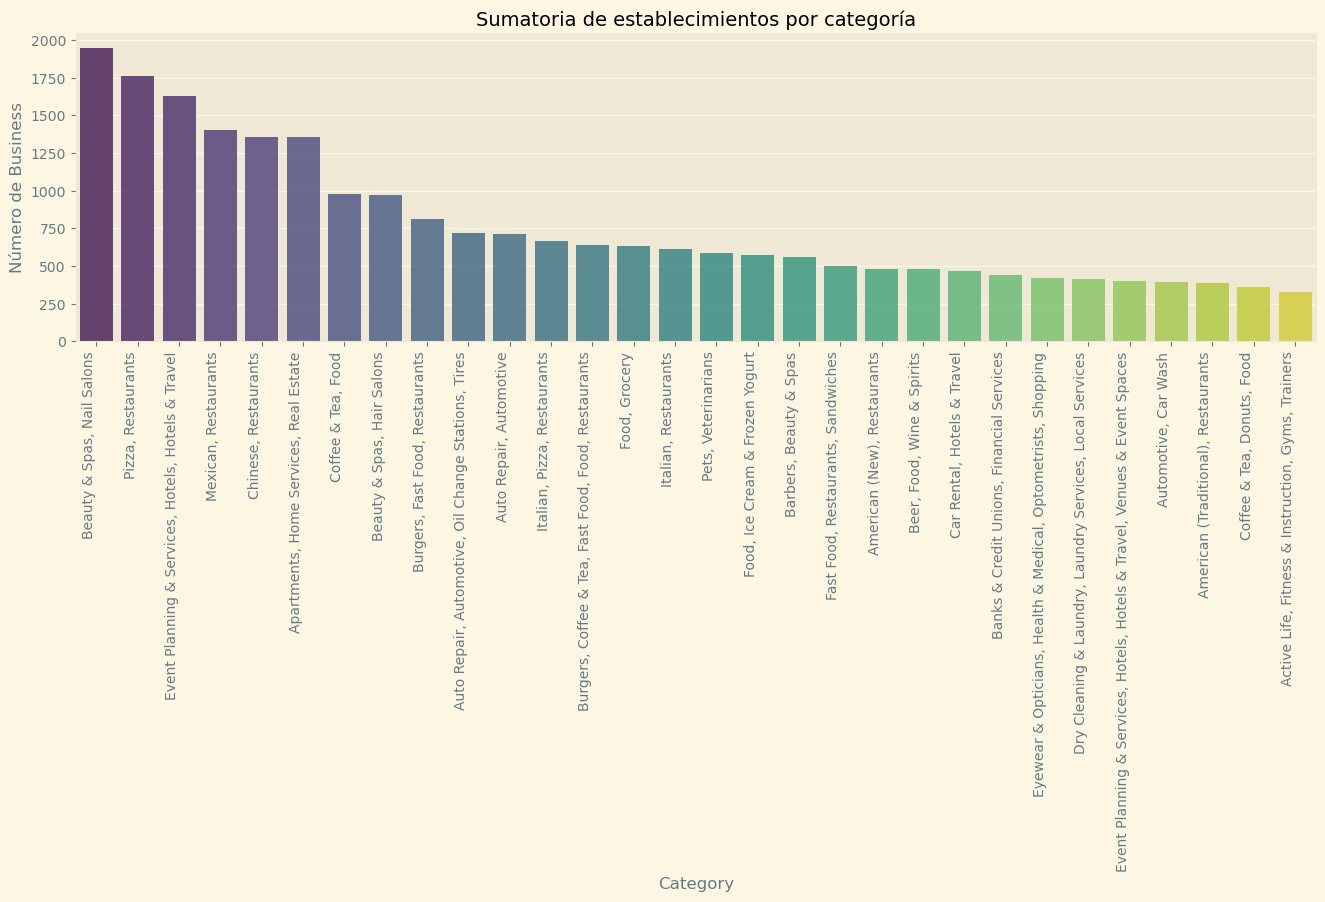

Total establecimientos: 23009 de 150346


In [26]:
# Convertir a pandas para graficar
df_category_counts_pd = df_count_categories_business_pl.to_pandas()
plt.figure(figsize=(16,4))
sns.barplot(x='categories', y='count',data=df_category_counts_pd, alpha=0.8, palette='viridis',hue='categories')
plt.title("Sumatoria de establecimientos por categoría",fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Número de Business', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()
print(f'Total establecimientos: {df_category_counts_pd['count'].sum()} de {df_data_business_pl.shape[0]}')


Extracción de los identificadores de los establecimientos que están dentro del conjunto de categorías más usadas.

In [27]:
# A continuación filtrar los business según las categorías seleccionadas
df_data_business_filer_pl = df_data_business_pl.filter(
    pl.col('categories').is_in(df_count_categories_business_pl['categories'])
)
print('-' * 50)
print(f'Total de establecimientos seleccionados {df_data_business_filer_pl.shape[0]}')
print('-' * 50)
display(df_data_business_filer_pl.head(2))

--------------------------------------------------
Total de establecimientos seleccionados 23009
--------------------------------------------------


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""9OG5YkX1g2GReZM0AskizA""","""Romano's Macaroni Grill""","""5505 S Virginia St""","""Reno""","""NV""","""89502""",39.476117,-119.789339,2.5,339,1,"{""{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"",""True"",""'casual'"",""True"",""True"",""True"",""True"",""'full_bar'"",""{u'divey': False, u'hipster': False, u'casual': True, u'touristy': False, u'trendy': False, u'intimate': False, u'romantic': None, u'classy': None, u'upscale': False}"",""True"",""2"",null,null,""False"",""True"",""True"",""True"",""u'free'"",null,""True"",""True"",null,""True"",""u'average'"",""{'dessert': None, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': None, 'breakfast': False}"",null,null,null,null,null,null,null,null}","""Italian, Restaurants""","{""11:0-22:0"",""11:0-22:0"",""10:0-22:0"",""11:0-20:0"",""11:0-21:0"",""12:0-21:0"",""11:0-21:0""}"
"""kV_Q1oqis8Qli8dUoGpTyQ""","""Ardmore Pizza""","""10 Rittenhouse Pl""","""Ardmore""","""PA""","""19003""",40.006707,-75.289671,3.5,109,1,"{""{'garage': False, 'street': True, 'validated': False, 'lot': True, 'valet': False}"",""True"",""u'casual'"",""False"",""False"",""True"",""True"",""u'none'"",""{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}"",""True"",""1"",null,null,null,null,""True"",""True"",""u'no'"",null,""True"",null,null,""True"",""u'average'"",""{'dessert': False, 'latenight': True, 'lunch': False, 'dinner': True, 'brunch': False, 'breakfast': False}"",null,null,null,null,null,null,null,null}","""Pizza, Restaurants""","{""11:0-0:0"",""11:0-0:0"",""11:0-0:0"",""11:0-0:0"",""11:0-1:0"",""11:0-1:0"",""11:0-0:0""}"


#### Review - Reseñas

A continuación observamos la distribución del conjunto total de las estrellas.

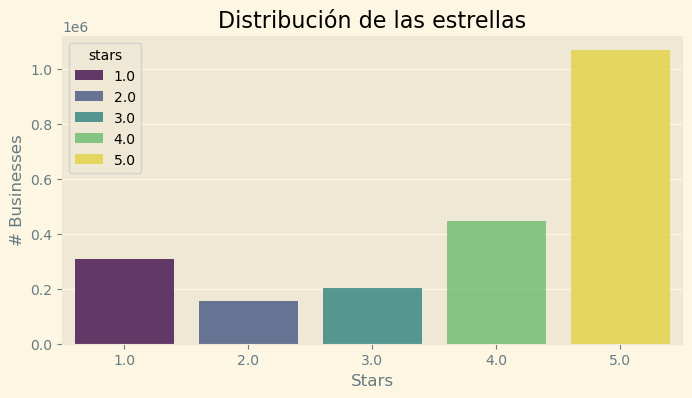

In [74]:
#Distribución grupal
x=df_data_review_pl['stars'].value_counts().sort('count', descending=True)
plt.figure(figsize=(8,4))
ax= sns.barplot(x='stars', y='count',data=x, alpha=0.8,hue='stars',palette='viridis')
plt.title("Distribución de las estrellas")
plt.ylabel('# Businesses', fontsize=12)
plt.xlabel('Stars', fontsize=12)
plt.show()

A continuación, realizamos la representación visual del top de establecimientos elegidos por la mayor cantidad de categorias usadas.

In [79]:
# A continuación filtra las reseñas por los business según las categorías seleccionadas  
df_data_reviews_filer_pl = df_data_review_pl.filter(
    pl.col('business_id').is_in(df_data_business_filer_pl['business_id'])
)
print('-' * 50)
print(f'Total de reseñas selecionadas de los establecimientos seleccionados {df_data_reviews_filer_pl.shape[0]} ' \
      'de un total de reseñas de: {df_data_review_pl.shape[0]}')
print('-' * 50)
display(df_data_reviews_filer_pl.head(2))

--------------------------------------------------
Total de reseñas selecionadas de los establecimientos seleccionados 237864 de un total de reseñas de: {df_data_review_pl.shape[0]}
--------------------------------------------------


review_id,user_id,business_id,stars,useful,funny,cool,text,date,length
str,str,str,f64,i64,i64,i64,str,str,u32
"""QH2xKMbQW5--cqj1kpznlg""","""spUcOhEOVW16Hk01WYzQMQ""","""jH1AttbdbqczQNpHorYH3g""",5.0,0,0,0,"""We love the food here. The pe…","""2014-11-30 04:05:07""",257
"""Dq8ywzHsPh4v33USrTjfPg""","""RSQSqDdPw7isN7vkxBYAlg""","""-qJUOsOCwODgEumCrQatTw""",4.0,0,0,0,"""Best broccoli in garlic sauce …","""2018-07-27 00:33:21""",257


A continuación, la representación visual de la distribución de las estrellas de las reseñas para los establecimientos seleccionados.  En el grafico podremos ver como usaremos reseñas dentro de todo el conjunto posible de calificación.

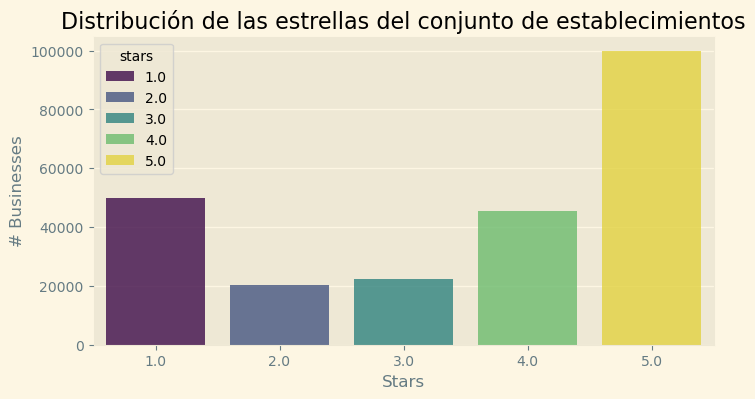

In [76]:
#Distribución grupal
x=df_data_reviews_filer_pl['stars'].value_counts().sort('count', descending=True)
plt.figure(figsize=(8,4))
ax= sns.barplot(x='stars', y='count',data=x, alpha=0.8,hue='stars',palette='viridis')
plt.title("Distribución de las estrellas del conjunto de establecimientos")
plt.ylabel('# Businesses', fontsize=12)
plt.xlabel('Stars', fontsize=12)
plt.show()

### Guardar las reseñas seleccionadas

In [80]:
# Guardar este DataFrame como archivo Parquet
df_data_reviews_selected_pl = df_data_reviews_filer_pl.select(pl.col('text'))
review_selected_file_path = r'./fakereviews/yelp_academic_dataset_review_selected.parquet'
df_data_reviews_selected_pl.write_parquet(review_selected_file_path)

# Información de sesión

In [88]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.10.0
numpy               2.0.1
pandas              2.2.3
polars              1.27.1
pyarrow             16.1.0
seaborn             0.13.2
session_info        v1.0.1
-----
IPython             9.1.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.3.4
notebook            7.3.2
-----
Python 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-04-20 20:15
